In [1]:
import os
import tarfile
from six.moves import urllib
# SE FIJAN LAS RUTAS DEL REPOSITIORIO DEL LIBRO
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [2]:
# AUTOMATIZAR LA DESCARGA Y EXTRACCION DEL ARCHIVO CON LA LIBRERIA TARFILE
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [7]:
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

In [9]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [10]:
housing["total_bedrooms"].isna().sum()

207

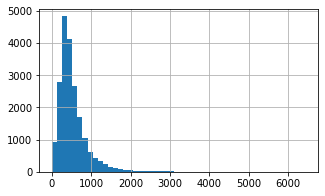

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
housing['total_bedrooms'].hist(bins=50, figsize=(5,3))
plt.show()

In [12]:
# ASI SE CREA UN TEST_SPLIT USANDO SOLO NUMPY
import numpy as np
shuffled_indices = np.random.permutation(len(housing))
test_set_size = int(len(housing) * 0.2)
test_indices = shuffled_indices[:test_set_size]
train_indices = shuffled_indices[test_set_size:]

In [13]:
housing["income_cat"] = pd.cut(housing["median_income"], 
                               bins=[0., 1.5, 3.0, 4.5, 6.,np.inf], 
                               labels=[1, 2, 3, 4, 5])

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
#     print(train_index, test_index)
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [15]:
strat_test_set['income_cat'].value_counts()/len(strat_test_set)

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [16]:
copy = strat_train_set.copy()

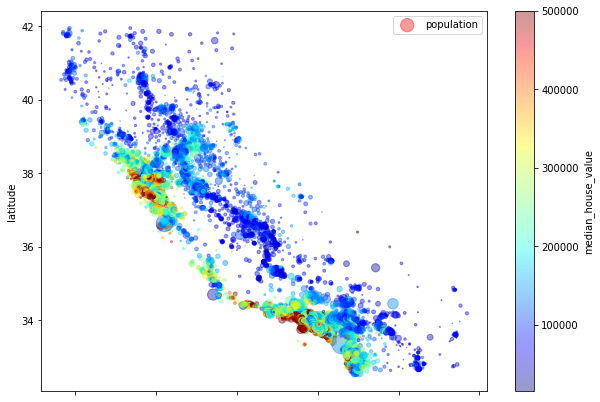

In [30]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
 s=housing["population"]/100, label="population", figsize=(10,7),
 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()


In [17]:
import seaborn as sns
corr = copy.corr()
corr['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [18]:
copy['bedrooms_per_housing'] = copy['total_rooms']/copy['households']
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [19]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [20]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [21]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [75]:
housing_cat = housing[["ocean_proximity"]]
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([[0.],
       [0.],
       [4.],
       ...,
       [1.],
       [0.],
       [3.]])

In [76]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [77]:
housing_1hot = pd.DataFrame(housing_cat_1hot.toarray(), columns=encoder.categories_)

In [78]:
housing_1hot

<1H OCEAN INLAND ISLAND NEAR BAY NEAR OCEAN
0           1.0    0.0    0.0      0.0        0.0
1           1.0    0.0    0.0      0.0        0.0
2           0.0    0.0    0.0      0.0        1.0
3           0.0    1.0    0.0      0.0        0.0
4           1.0    0.0    0.0      0.0        0.0
...         ...    ...    ...      ...        ...
16507       0.0    1.0    0.0      0.0        0.0
16508       0.0    1.0    0.0      0.0        0.0
16509       0.0    1.0    0.0      0.0        0.0
16510       1.0    0.0    0.0      0.0        0.0
16511       0.0    0.0    0.0      1.0        0.0

[16512 rows x 5 columns]

In [79]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [80]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [81]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([('imp', SimpleImputer(strategy='median')),
                    ('atrr_adder', CombinedAttributesAdder()),
                    ('std_scaler', StandardScaler()),
                    ])
housing_num_pipe = pipeline.fit_transform(housing_num)

In [82]:
# COLUMN TRANSFORMER PARA TRABAJAR CON TODAS LAS COLUMNAS SIN IMPORTAR SI SON CATEGORICAS O NUMERICAS.
# ESTO ES POSIBLE GRACIAS A COLUMNTRANSFORMER() CLASS, ELLA TOMA UNA PIPELINE Y UN ENCODER A LA VEZ

from sklearn.compose import ColumnTransformer

num_atributes = list(housing_num)
cat_atributes = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ("num", pipeline, num_atributes),
    ("cat", OneHotEncoder(), cat_atributes),
])

housing_prepared = full_pipeline.fit_transform(housing)

In [117]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression(normalize=True)
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(normalize=True)

In [118]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared), "\n\n")
print("Labels:", list(some_labels))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879] 


Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [119]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [120]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
lin_reg_scores = np.sqrt(-scores)

def print_metrics(scores):
    print("Scores:", scores, "\n")
    print("Mean:", scores.mean(), "\n")
    print("Standard deviation:", scores.std(), "\n")

print_metrics(lin_reg_scores)

Scores: [66791.08170334 66958.08754699 70341.03974965 74757.07316495
 68031.13388938 71196.25873501 64961.41457209 68280.79400307
 71550.6740428  67665.10082067] 

Mean: 69053.26582279516 

Standard deviation: 2735.6938873441895 



In [121]:
# USANDO EL GRIDSEARCH PARA ENCONTRAR LOS HIPERPARAMETROS IDEALES Y MAXIMIZAR EL MODELO
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(lin_reg, param_grid=[{'copy_X': [True], 'fit_intercept' : [True], 'normalize' : [True]}], cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)



In [122]:
grid_search.fit(housing_prepared, housing_labels)
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [125]:
from sklearn.svm import SVR

svm_reg = SVR(kernel='linear')
svm_reg.fit(housing_prepared, housing_labels)
svm_house_pred = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

68628.19819848923